In [ ]:
import pandas as pd 
import numpy as np
import operator
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import  MinMaxScaler #stardadizzo i valori a intervallo [0,1]
from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [ ]:
input = pd.read_csv("/content/drive/My Drive/dati/dati_experiment/file2.csv") #Carico dataset
data_obj = pd.DataFrame(input)

data_obj_droped = data_obj.drop(columns=['PSA', 'ETA','STATUS','Tipologia'])
col_status = data_obj['STATUS']
col_typology = data_obj['Tipologia']

data = {"STATUS": col_status, "Tipologia": col_typology} 
data_class = pd.concat(data, axis = 1) 

tuple_class = list(map(tuple, data_class.to_numpy())) #M=2, T=1, N=0
#print(len(tuple_class))  #45 sample
encode_tuple = { (0,0) : 1, (0,1) : 2, (0,2) : 3, (1,0) : 4, (1,1) : 5, (1,2) : 6}
macro_class = []
for couple in tuple_class: 
  macro_class.append(encode_tuple[couple])

series_macro_class = pd.Series((v for v in macro_class) )
print("NUMERO DI TUPLE PER CLASSE MACRO:")
series_macro_class.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NUMERO DI TUPLE PER CLASSE MACRO:


2    12
6     9
1     8
5     7
4     6
3     3
dtype: int64

#Computo su K-fold: SVM, Logistic Regression, NB, Random Forest, KNN

In [ ]:
n_fold = 5
fold_obj = StratifiedKFold(n_fold ,  True, random_state = 4)  # 5 fold, shuffle=true
print(fold_obj)
print(len(data_obj_droped)) #45
y = data_obj['STATUS'] 

StratifiedKFold(n_splits=5, random_state=4, shuffle=True)
45


In [ ]:
#Strutture utili per immagazzinamento risultati degli esperimenti
#n = data_objs_oversampling #.to_numpy()
n = data_obj_droped
test_predicted_logit = np.zeros((np.array(n).shape[0],))
test_predicted_svc = np.zeros((np.array(n).shape[0],))
test_predicted_bayes = np.zeros((np.array(n).shape[0],))
test_predicted_clf =  np.zeros((np.array(n).shape[0],))
test_predicted_knn =  np.zeros((np.array(n).shape[0],))

In [ ]:
#STANDARDIZZAZIONE
#StandardScaler(with_std=True) o #MinMaxScaler()
scaler = MinMaxScaler()   
scaler.fit(data_obj_droped) #  data_obj_droped: dataframe senza le colonne: PSA ETA  STATUS Tipologia
data_objs = scaler.transform(data_obj_droped) 
data_objs

array([[0.00e+00, 0.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [5.14e-05, 2.35e-06, 1.00e+00, ..., 9.68e-06, 0.00e+00, 1.00e+00],
       [3.08e-04, 6.50e-05, 1.00e+00, ..., 1.22e-01, 7.79e-06, 1.00e+00],
       ...,
       [1.42e-01, 3.30e-04, 9.72e-01, ..., 9.16e-01, 2.74e-04, 0.00e+00],
       [5.60e-01, 1.66e-03, 8.77e-01, ..., 3.51e-03, 6.96e-01, 9.99e-01],
       [1.00e+00, 2.31e-03, 7.99e-01, ..., 5.55e-03, 1.00e+00, 9.98e-01]])

In [ ]:
#Funzione per fare oversampling solo sul training (nella fase di K-fold split)
def oversampling_training(dataset_training, y_status, y_tipology): 
  data = {"STATUS": y_status, "Tipologia": y_tipology} 
  data_class = pd.concat(data, axis = 1) 
  tuple_class = list(map(tuple, data_class.to_numpy()))
  #print(len(tuple_class))  #45 sample
  encode_tuple = { (0,0) : 1, (0,1) : 2, (0,2) : 3, (1,0) : 4, (1,1) : 5, (1,2) : 6}
  macro_class = []
  for couple in tuple_class: 
    macro_class.append(encode_tuple[couple])

  series_macro_class = pd.Series((v for v in macro_class) )
  #print(series_macro_class)
  #print("NUMERO DI TUPLE PER CLASSE MACRO:")
  #print(series_macro_class.value_counts())

  #oversampling "NORMALE"                                
  oversample = SMOTE(k_neighbors=1)#Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3
  data_objs_oversampling, macro_class_oversampling = oversample.fit_resample(dataset_training, series_macro_class)

  macro= pd.Series((v for v in macro_class_oversampling) )
  #print(series_macro_class) 
  print("NUMERO DI TUPLE PER CLASSE MACRO:")
  print(macro.value_counts())
  #DALL'OVERSAMPLING DELLA MACRO_CLASS DEVO CODIFICARE LE NUOVE ETICHETTE
  micro_class = list()
  for encoded in macro_class_oversampling: 
    #print(encoded)
    for key, value in encode_tuple.items():  #  in dictionary.iteritems():  (for Python 2.x)
      if encoded == value:
          #print(key)
          micro_class.append(key)
  #print(micro_class)
  new_df = pd.DataFrame(micro_class, columns=['STATUS', 'Tipologia'])
  #print(new_df)
  y=new_df['STATUS']
  #print(y)
  #print("Nuova lunghezza del vettore target y (dopo l'oversampling): ", len(y))
  return data_objs_oversampling, y
  

In [ ]:
import itertools
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center")
                # color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#TEN_RUN MINMAXSCALER e STANDARDSCALER, OVERSAMPLING, NO PCA 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 1
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
[[13 10]
 [13  9]]
Confusion matrix, without normalization
[[13 10]
 [13  9]]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
[[11 12]
 [ 9 13]]
Confusion matrix, without normalization
[[11 12]
 [ 9 13]]
[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.]
[[ 9 14]
 [12 10]]
Confusion matrix, without normalization
[[ 9 14]
 [12 10]]
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
[[14  9]
 [10 12]]
Confusion matrix, without normalization
[[14  9]

KeyboardInterrupt: ignored

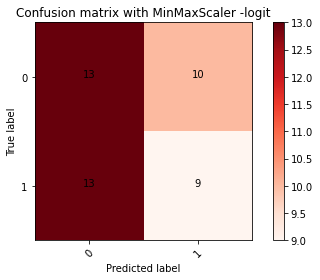

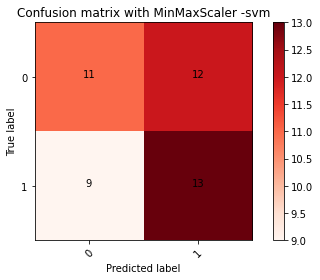

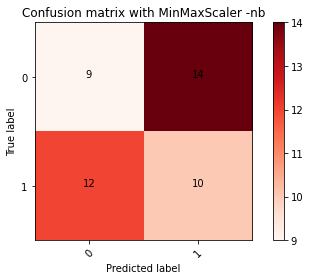

<Figure size 432x288 with 0 Axes>

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

for exec in range(1,11):
  #NO PCA
  i=0

  dict_model = { "logit": {"accuracy": [], "precision": [], "recall": []},
                  "svm": {"accuracy": [], "precision": [], "recall": []},
                  "rf": {"accuracy":  [], "precision": [], "recall": []}, 
                  "nb": {"accuracy":  [], "precision": [], "recall": []},
                  "knn": {"accuracy":  [], "precision": [], "recall": []},
                }

  for train_idx, test_idx in fold_obj.split(data_objs, y):  
        i += 1
      
        X_train, X_test = data_objs[train_idx, :], data_objs[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]

        dataset_training = data_objs[train_idx, :]
        y_status = y[train_idx]
        y_tipology = col_typology[train_idx]
        
            
        #fare oversampling su X_train e y_train
        #oversampling_training(dataset_training, y_status, y_tipology) #Test only function

        X_oversampled, y_oversampled = oversampling_training(dataset_training, y_status, y_tipology)

        #print("X_train oversampled", len(X_oversampled))
        #print("y_train oversampled", len(y_oversampled))

        X_train = X_oversampled
        y_train = y_oversampled

        print("TRAINING sample: ", len(X_train))
        print("TEST sample: ", len(X_test))

        #BUILD Logit
        logisticRegr = LogisticRegression(solver = 'lbfgs')  # handle L2 or no penalty
        logisticRegr.fit(X_train, y_train)
        test_predicted_logit[test_idx]  = logisticRegr.predict(X_test)
        print("Fold: " + str(i))


        #print("\t Accuracy Logit: %", accuracy_score(y_test, test_predicted_logit[test_idx])*100)

        #BUILD SVC
        model_svc = SVC(kernel='rbf')
        model_svc.fit(X_train, y_train) 
        test_predicted_svc[test_idx] = model_svc.predict(X_test)
     
        #print("\t Accuracy SVM: %", accuracy_score(y_test, test_predicted_svc[test_idx])*100)

        #BUILD RANDOM FOREST 
        clf = RandomForestClassifier(max_depth=None, random_state=0)
        clf.fit(X_train, y_train) 
        test_predicted_clf[test_idx] = clf.predict(X_test)
        #print("\t Accuracy RF:  %", accuracy_score(y_test, test_predicted_clf[test_idx])*100) 
        
        from sklearn.naive_bayes import GaussianNB
        #BUILD NAIVE BAYESIAN 
        model_naiveBay = GaussianNB()
        model_naiveBay.fit(X_train, y_train)
        test_predicted_bayes[test_idx] = model_naiveBay.predict(X_test)
        #print("\t Accuracy NB:  %", accuracy_score(y_test, test_predicted_bayes[test_idx])*100)

        #BUILD KNN
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X_train, y_train)
        test_predicted_knn[test_idx] = neigh.predict(X_test)


  print("End of kfold") 

  # Compute confusion matrix
  label = ["logit", "svm", "nb", "rf", "knn"]  
  dict_pred = {  "logit": {"y_pred": []},
                  "svm": {"y_pred": []},
                  "rf":  {"y_pred": []},
                  "nb":  {"y_pred": []},
                  "knn":  {"y_pred": []}, 
                }
    #SVM
  dict_pred['svm']['y_pred'].append(test_predicted_svc)
    #Logit 
  dict_pred['logit']['y_pred'].append(test_predicted_logit)
    #Rf
  dict_pred['rf']['y_pred'].append(test_predicted_clf)
    #Nb
  dict_pred['nb']['y_pred'].append(test_predicted_bayes)
    #Nb
  dict_pred['knn']['y_pred'].append(test_predicted_knn)

  for name in label: 
    y_pred = dict_pred[name]['y_pred']
    print(y_pred[0])
    cnf_matrix = confusion_matrix(y, y_pred[0])
    np.set_printoptions(precision=2)
    print(cnf_matrix)
    plt.figure()
    tit = 'Confusion matrix with MinMaxScaler -' + name 
    plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                          title= tit)
    #plt.savefig('/content/drive/My Drive/dati/last_test/Plot/' + tit +'.png')


  print("\n\nRisultati metriche: \n")

  print("Accuracy SVM: ", accuracy_score(y,test_predicted_svc))
  print("Accuracy RF: ", accuracy_score(y,test_predicted_clf))
  print("Accuracy NB: ", accuracy_score(y,test_predicted_bayes))
  print("Accuracy LOGIT: ", accuracy_score(y,test_predicted_logit))
  print("Accuracy KNN: ", accuracy_score(y,test_predicted_knn))

  print("\nPrecision SVM: ", precision_score(y,test_predicted_svc))
  print("Precision RF: ", precision_score(y,test_predicted_clf))
  print("Precision NB: ", precision_score(y,test_predicted_bayes))
  print("Precision LOGIT: ", precision_score(y,test_predicted_logit))
  print("Precision KNN: ", precision_score(y,test_predicted_knn))

  print("\nRecall SVM: ", recall_score(y,test_predicted_svc))
  print("Recall RF: ", recall_score(y,test_predicted_clf))
  print("Recall NB: ", recall_score(y,test_predicted_bayes))
  print("Recall LOGIT: ", recall_score(y,test_predicted_logit))
  print("Recall KNN: ", recall_score(y,test_predicted_knn))

  #plot_confusion_matrix(clf, data_objs, y)  # doctest: +SKIP
  #plt.show() 

    #SVM
  dict_model['svm']['accuracy'].append(accuracy_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['accuracy'].append(accuracy_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['accuracy'].append(accuracy_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['accuracy'].append(accuracy_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['accuracy'].append(accuracy_score(y, test_predicted_knn))


    #SVM
  dict_model['svm']['precision'].append(precision_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['precision'].append(precision_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['precision'].append(precision_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['precision'].append(precision_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['precision'].append(precision_score(y, test_predicted_knn))



    #SVM
  dict_model['svm']['recall'].append(recall_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['recall'].append(recall_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['recall'].append(recall_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['recall'].append(recall_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['recall'].append(recall_score(y, test_predicted_knn))

  #j=0

  
  for key in dict_model.keys():   
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(exec)  + 'accuracy_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['accuracy']))
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(exec)  + 'precision_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['precision']))
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(exec)  + 'recall_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['recall']))
     np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(exec)  + 'accuracy_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['accuracy']))
     np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(exec)  + 'precision_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['precision']))
     np.save('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(exec)  + 'recall_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['recall']))
  dict_model.clear()
  dict_pred.clear()


[(0.5333333333333333, 0.4888888888888889, 0.37777777777777777, 0.4444444444444444, 0.4888888888888889, 0.37777777777777777, 0.4666666666666667, 0.37777777777777777, 0.4444444444444444, 0.4888888888888889), (0.5555555555555556, 0.5111111111111111, 0.4888888888888889, 0.4666666666666667, 0.4666666666666667, 0.5333333333333333, 0.5555555555555556, 0.4666666666666667, 0.4666666666666667, 0.4888888888888889), (0.4888888888888889, 0.4888888888888889, 0.5333333333333333, 0.4888888888888889, 0.5333333333333333, 0.4888888888888889, 0.4888888888888889, 0.5111111111111111, 0.4888888888888889, 0.4888888888888889), (0.7111111111111111, 0.6666666666666666, 0.5555555555555556, 0.6888888888888889, 0.6444444444444445, 0.6444444444444445, 0.5777777777777777, 0.6, 0.5777777777777777, 0.6666666666666666)]
       Run1      Run2      Run3  ...      Run9     Run10  mean_accuracy
0  0.533333  0.488889  0.377778  ...  0.444444  0.488889       0.448889
1  0.555556  0.511111  0.488889  ...  0.466667  0.488889   

<Figure size 432x288 with 0 Axes>

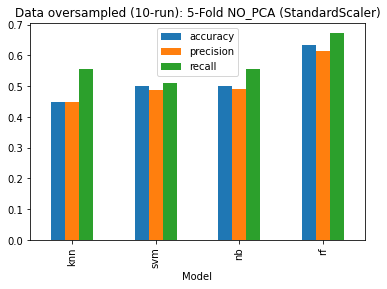

In [ ]:
#PLOT TEN_RUN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_fold = 5
      #    0,    1   ,    2    ,3 
label = ["knn", "svm", "nb", "rf"]  
label_step =["Run1", "Run2","Run3","Run4","Run5","Run6","Run7","Run8","Run9", "Run10"]
dict_metrics = {"accuracy":[], "precision": [], "recall": []}
data_acc =[]
data_pre = []
data_rec = []


temp = []
for item in label:
  for e in range(1,11):

    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(e) + 'accuracy_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(e) + 'accuracy_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_acc.append(tuple(temp))
  temp.clear()

print(data_acc)


df_acc = pd.DataFrame(data_acc, columns = label_step) 

df_acc['mean_accuracy'] = df_acc.mean(axis=1)
print(df_acc)

#calcolo media precision su 10 run
for item in label:
  for e in range(1,11):

    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(e) + 'precision_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(e) + 'precision_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_pre.append(tuple(temp))
  temp.clear()

print(data_pre)


df_pre = pd.DataFrame(data_pre, columns = label_step) 
df_pre['mean_precision'] = df_pre.mean(axis=1)
print(df_pre)


#calcolo media recall su 10 run
for item in label:
  for e in range(1,11):

    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/MinMaxScaler/'+ str(e) + 'recall_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/StandardScaler/'+ str(e) + 'recall_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_rec.append(tuple(temp))
  temp.clear()

print(data_rec)


df_rec = pd.DataFrame(data_rec, columns = label_step) 
df_rec['mean_recall'] = df_rec.mean(axis=1)
print(df_rec)

item_l, item_precision, item_recall = [] , [] , []
item_l = df_acc['mean_accuracy'].tolist()
item_precision =df_pre['mean_precision'].tolist()
item_recall =df_rec['mean_recall'].tolist() 

print(item_l)
print(item_precision)
print(item_recall)
for i in range(0, len(label)):
 df_acc = df_acc.rename(index={i: label[i]})
print(df_acc)
ax = sns.heatmap(df_acc, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_acc = ax.get_figure()
#fig_acc.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_minmax/' + "df_acc"  +".png")
fig_acc.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_standardScaler/' + "df_acc"  +".png")
fig_acc.clear()

for i in range(0, len(label)):
 df_pre = df_pre.rename(index={i: label[i]})
print(df_pre)
ax_pre = sns.heatmap(df_pre, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_pre = ax_pre.get_figure()
#fig_pre.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_minmax/' + "df_pre"  +".png")
fig_pre.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_standardScaler/' + "df_pre"  +".png")
fig_pre.clear()
for i in range(0, len(label)):
 df_rec = df_rec.rename(index={i: label[i]})
print(df_rec)
ax_rec= sns.heatmap(df_rec, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_rec = ax_rec.get_figure()
#fig_rec.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_minmax/' + "df_rec"  +".png")
fig_rec.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/dataframe/df_standardScaler/' + "df_rec"  +".png")
fig_rec.clear()

df = pd.DataFrame({'accuracy':item_l,'precision': item_precision, 'recall': item_recall, 'Model': label})
title = "Data oversampled (10-run): " + str(n_fold) + "-Fold " + "NO_PCA (MinMaxScaler)"
title2 = "Data oversampled (10-run): " + str(n_fold) + "-Fold " + "NO_PCA (StandardScaler)" 
plot = df.plot(x= 'Model', kind='bar', legend=True, title = title2)
fig = plot.get_figure()
#fig.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/' + title + '.png')
fig.savefig('/content/drive/My Drive/dati/last_test/ten_run/NO_PCA/oversampling/PLOT/' + title2 + '.png')


#PCA con oversampling (STANDARD SCALER e/o MINMAX Ten run

[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.04
 0.04 0.04]
Varianza mantenuta:  % 95
Componenti Pricipali:  30
NUMERO DI TUPLE PER CLASSE MACRO:
6    9
5    9
4    9
3    9
2    9
1    9
dtype: int64
TRAINING sample:  54
TEST sample:  9
Fold: 1
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[11 12]
 [13  9]]
Confusion matrix, without normalization
[[11 12]
 [ 8 14]]
Confusion matrix, without normalization
[[15  8]
 [ 6 16]]
Confusion matrix, without normalization
[[14  9]
 [ 6 16]]
Confusion matrix, without normalization
[[12 11]
 [11 11]]


Risultati metriche: 

Accuracy SVM:  0.5555555555555556
Accuracy RF:  0.6666666666666666
Accuracy NB:  0.6888888888888889
Accuracy LOGIT:  0.4444444444444444
Accuracy KNN:  0.5111111111111111

Precision SVM:  0.5384615384615384
Precision RF:  0.64
Precision NB:  0.6666666666666666
Precision LOGIT:  0.42857142857142855
Precision KNN:  0.5

Recall SVM:  0.6363636363636364
Recall RF:  0.7272727272727273
Recall NB:  0.7272727272727273
Recall LOGIT:  0.4090909090909091
Recall KNN:  0.5
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2
NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4
NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

End of kfold
Confusion matrix, without normalization
[[12 11]
 [11 11]]
Confusion matrix, without normalization
[[10 13]
 [10 12]]
Confusion matrix, without normalization
[[15  8]
 [ 7 15]]
Confusion matrix, without normalization
[[14  9]
 [ 8 14]]
Confusion matrix, without normalization
[[11 12]
 [10 12]]


Risultati metriche: 

Accuracy SVM:  0.4888888888888889
Accuracy RF:  0.6222222222222222
Accuracy NB:  0.6666666666666666
Accuracy LOGIT:  0.5111111111111111
Accuracy KNN:  0.5111111111111111

Precision SVM:  0.48
Precision RF:  0.6086956521739131
Precision NB:  0.6521739130434783
Precision LOGIT:  0.5
Precision KNN:  0.5

Recall SVM:  0.5454545454545454
Recall RF:  0.6363636363636364
Recall NB:  0.6818181818181818
Recall LOGIT:  0.5
Recall KNN:  0.5454545454545454
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.04
 0.04 0.04]
Varianza mantenuta:  % 95
Componenti Pricipali:  30
NUMERO DI TUPL

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[14  9]
 [13  9]]
Confusion matrix, without normalization
[[12 11]
 [ 8 14]]
Confusion matrix, without normalization
[[15  8]
 [ 5 17]]
Confusion matrix, without normalization
[[14  9]
 [ 7 15]]
Confusion matrix, without normalization
[[12 11]
 [10 12]]


Risultati metriche: 

Accuracy SVM:  0.5777777777777777
Accuracy RF:  0.6444444444444445
Accuracy NB:  0.7111111111111111
Accuracy LOGIT:  0.5111111111111111
Accuracy KNN:  0.5333333333333333

Precision SVM:  0.56
Precision RF:  0.625
Precision NB:  0.68
Precision LOGIT:  0.5
Precision KNN:  0.5217391304347826

Recall SVM:  0.6363636363636364
Recall RF:  0.6818181818181818
Recall NB:  0.7727272727272727
Recall LOGIT:  0.4090909090909091
Recall KNN:  0.5454545454545454
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2
NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4
NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

End of kfold
Confusion matrix, without normalization
[[14  9]
 [11 11]]
Confusion matrix, without normalization
[[11 12]
 [ 8 14]]
Confusion matrix, without normalization
[[13 10]
 [ 8 14]]
Confusion matrix, without normalization
[[17  6]
 [ 8 14]]
Confusion matrix, without normalization
[[ 9 14]
 [ 7 15]]


Risultati metriche: 

Accuracy SVM:  0.5555555555555556
Accuracy RF:  0.6888888888888889
Accuracy NB:  0.6
Accuracy LOGIT:  0.5555555555555556
Accuracy KNN:  0.5333333333333333

Precision SVM:  0.5384615384615384
Precision RF:  0.7
Precision NB:  0.5833333333333334
Precision LOGIT:  0.55
Precision KNN:  0.5172413793103449

Recall SVM:  0.6363636363636364
Recall RF:  0.6363636363636364
Recall NB:  0.6363636363636364
Recall LOGIT:  0.5
Recall KNN:  0.6818181818181818
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.04
 0.04 0.04]
Varianza mantenuta:  % 95
Componenti Pricipali:  30
NUMERO DI TUPL

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[12 11]
 [13  9]]
Confusion matrix, without normalization
[[11 12]
 [10 12]]
Confusion matrix, without normalization
[[16  7]
 [ 6 16]]
Confusion matrix, without normalization
[[15  8]
 [ 5 17]]
Confusion matrix, without normalization
[[10 13]
 [ 9 13]]


Risultati metriche: 

Accuracy SVM:  0.5111111111111111
Accuracy RF:  0.7111111111111111
Accuracy NB:  0.7111111111111111
Accuracy LOGIT:  0.4666666666666667
Accuracy KNN:  0.5111111111111111

Precision SVM:  0.5
Precision RF:  0.68
Precision NB:  0.6956521739130435
Precision LOGIT:  0.45
Precision KNN:  0.5

Recall SVM:  0.5454545454545454
Recall RF:  0.7727272727272727
Recall NB:  0.7272727272727273
Recall LOGIT:  0.4090909090909091
Recall KNN:  0.5909090909090909
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2
NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4
NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

End of kfold
Confusion matrix, without normalization
[[13 10]
 [12 10]]
Confusion matrix, without normalization
[[11 12]
 [ 8 14]]
Confusion matrix, without normalization
[[13 10]
 [ 5 17]]
Confusion matrix, without normalization
[[15  8]
 [ 9 13]]
Confusion matrix, without normalization
[[13 10]
 [12 10]]


Risultati metriche: 

Accuracy SVM:  0.5555555555555556
Accuracy RF:  0.6222222222222222
Accuracy NB:  0.6666666666666666
Accuracy LOGIT:  0.5111111111111111
Accuracy KNN:  0.5111111111111111

Precision SVM:  0.5384615384615384
Precision RF:  0.6190476190476191
Precision NB:  0.6296296296296297
Precision LOGIT:  0.5
Precision KNN:  0.5

Recall SVM:  0.6363636363636364
Recall RF:  0.5909090909090909
Recall NB:  0.7727272727272727
Recall LOGIT:  0.45454545454545453
Recall KNN:  0.45454545454545453
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.04
 0.04 0.04]
Varianza mantenuta:  % 95
Component

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[13 10]
 [12 10]]
Confusion matrix, without normalization
[[12 11]
 [ 9 13]]
Confusion matrix, without normalization
[[14  9]
 [ 8 14]]
Confusion matrix, without normalization
[[13 10]
 [ 9 13]]
Confusion matrix, without normalization
[[12 11]
 [ 9 13]]


Risultati metriche: 

Accuracy SVM:  0.5555555555555556
Accuracy RF:  0.5777777777777777
Accuracy NB:  0.6222222222222222
Accuracy LOGIT:  0.5111111111111111
Accuracy KNN:  0.5555555555555556

Precision SVM:  0.5416666666666666
Precision RF:  0.5652173913043478
Precision NB:  0.6086956521739131
Precision LOGIT:  0.5
Precision KNN:  0.5416666666666666

Recall SVM:  0.5909090909090909
Recall RF:  0.5909090909090909
Recall NB:  0.6363636363636364
Recall LOGIT:  0.45454545454545453
Recall KNN:  0.5909090909090909
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 2
NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4
NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

End of kfold
Confusion matrix, without normalization
[[12 11]
 [11 11]]
Confusion matrix, without normalization
[[12 11]
 [ 8 14]]
Confusion matrix, without normalization
[[14  9]
 [ 6 16]]
Confusion matrix, without normalization
[[15  8]
 [ 7 15]]
Confusion matrix, without normalization
[[12 11]
 [10 12]]


Risultati metriche: 

Accuracy SVM:  0.5777777777777777
Accuracy RF:  0.6666666666666666
Accuracy NB:  0.6666666666666666
Accuracy LOGIT:  0.5111111111111111
Accuracy KNN:  0.5333333333333333

Precision SVM:  0.56
Precision RF:  0.6521739130434783
Precision NB:  0.64
Precision LOGIT:  0.5
Precision KNN:  0.5217391304347826

Recall SVM:  0.6363636363636364
Recall RF:  0.6818181818181818
Recall NB:  0.7272727272727273
Recall LOGIT:  0.5
Recall KNN:  0.5454545454545454
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 0.11 0.1  0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.05 0.05 0.05 0.04
 0.04 0.04]
Varianza mantenuta:  % 95
Componenti Pricipali:  30
NUMERO DI TUP

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[13 10]
 [11 11]]
Confusion matrix, without normalization
[[11 12]
 [ 9 13]]
Confusion matrix, without normalization
[[13 10]
 [ 7 15]]
Confusion matrix, without normalization
[[16  7]
 [10 12]]
Confusion matrix, without normalization
[[12 11]
 [10 12]]


Risultati metriche: 

Accuracy SVM:  0.5333333333333333
Accuracy RF:  0.6222222222222222
Accuracy NB:  0.6222222222222222
Accuracy LOGIT:  0.5333333333333333
Accuracy KNN:  0.5333333333333333

Precision SVM:  0.52
Precision RF:  0.631578947368421
Precision NB:  0.6
Precision LOGIT:  0.5238095238095238
Precision KNN:  0.5217391304347826

Recall SVM:  0.5909090909090909
Recall RF:  0.5454545454545454
Recall NB:  0.6818181818181818
Recall LOGIT:  0.5
Recall KNN:  0.5454545454545454
[1.04 0.6  0.39 0.33 0.3  0.27 0.26 0.24 0.19 0.17 0.16 0.14 0.13 0.11
 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    11
5    11
4    11
3    11
2    11
1    11
dtype: int64
TRAINING sample:  66
TEST sample:  9
Fold: 3
NUMERO DI TUPLE PER CLASSE MACRO:
6    10
5    10
4    10
3    10
2    10
1    10
dtype: int64
TRAINING sample:  60
TEST sample:  9
Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NUMERO DI TUPLE PER CLASSE MACRO:
6    8
5    8
4    8
3    8
2    8
1    8
dtype: int64
TRAINING sample:  48
TEST sample:  9
Fold: 5
End of kfold
Confusion matrix, without normalization
[[15  8]
 [10 12]]
Confusion matrix, without normalization
[[12 11]
 [ 8 14]]
Confusion matrix, without normalization
[[15  8]
 [ 6 16]]
Confusion matrix, without normalization
[[20  3]
 [ 7 15]]
Confusion matrix, without normalization
[[12 11]
 [10 12]]


Risultati metriche: 

Accuracy SVM:  0.5777777777777777
Accuracy RF:  0.7777777777777778
Accuracy NB:  0.6888888888888889
Accuracy LOGIT:  0.6
Accuracy KNN:  0.5333333333333333

Precision SVM:  0.56
Precision RF:  0.8333333333333334
Precision NB:  0.6666666666666666
Precision LOGIT:  0.6
Precision KNN:  0.5217391304347826

Recall SVM:  0.6363636363636364
Recall RF:  0.6818181818181818
Recall NB:  0.7272727272727273
Recall LOGIT:  0.5454545454545454
Recall KNN:  0.5454545454545454


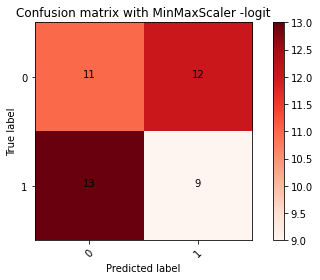

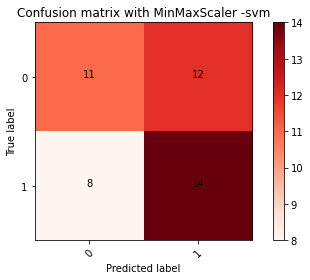

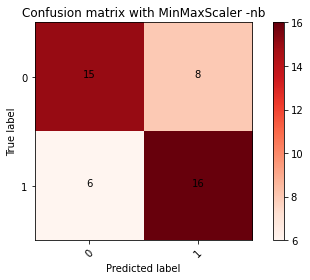

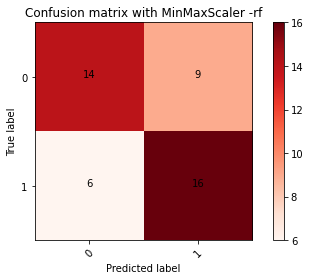

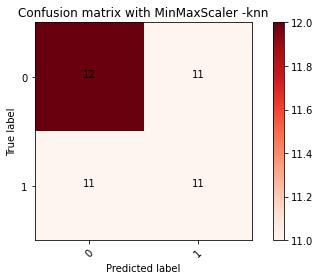

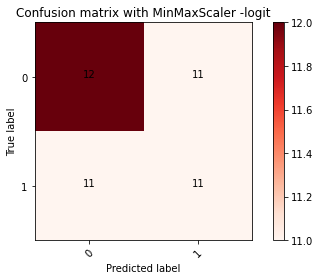

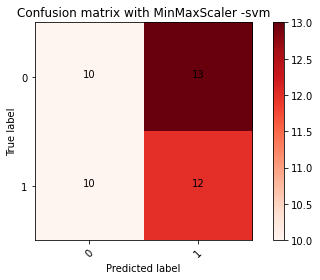

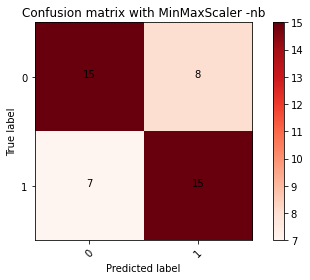

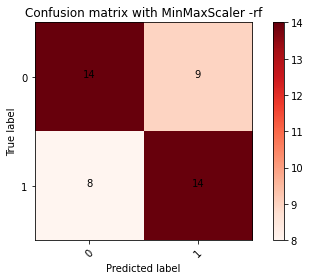

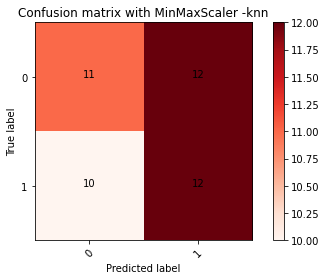

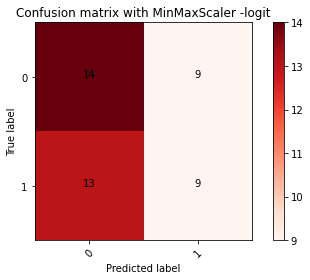

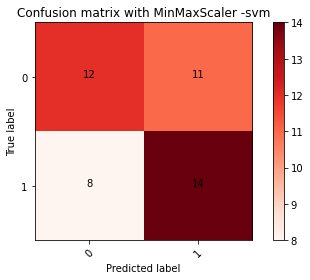

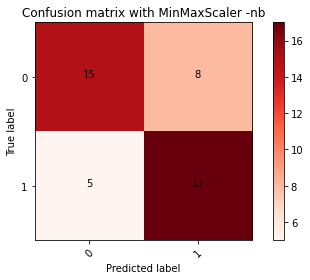

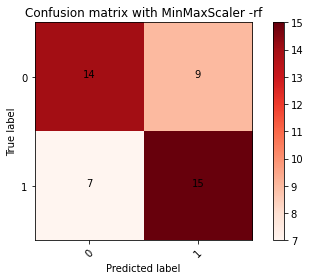

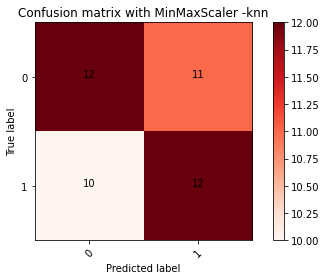

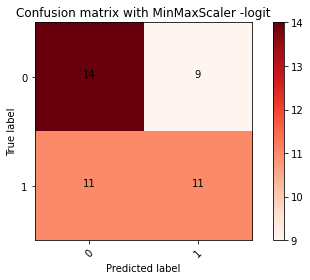

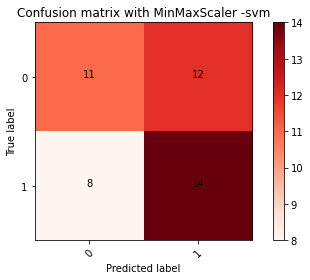

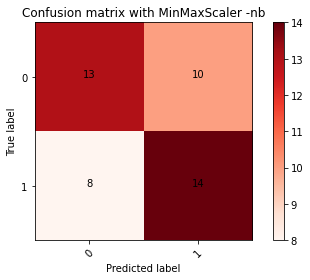

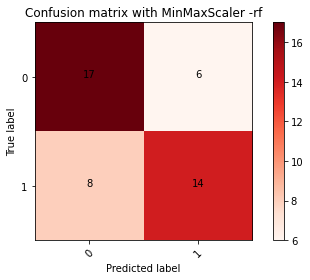

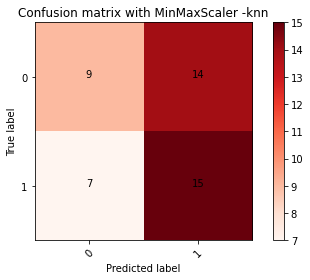

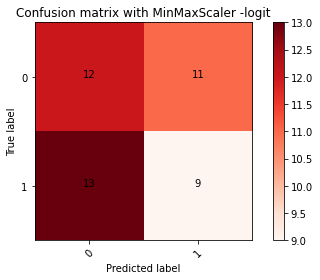

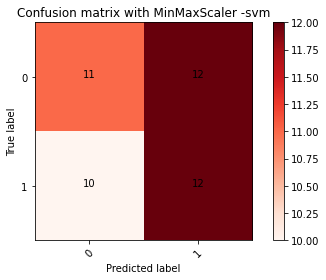

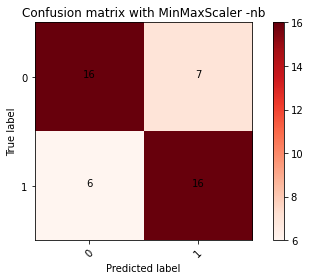

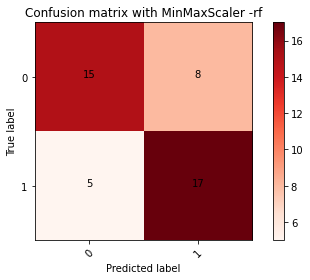

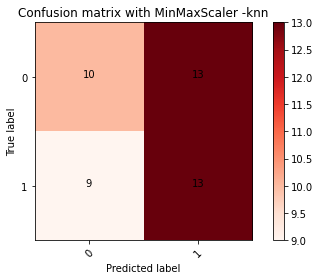

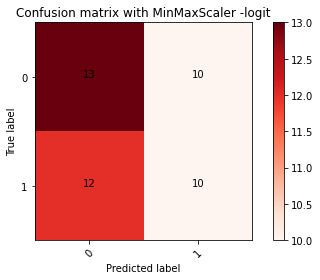

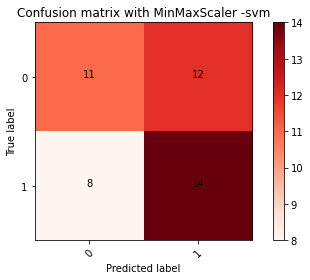

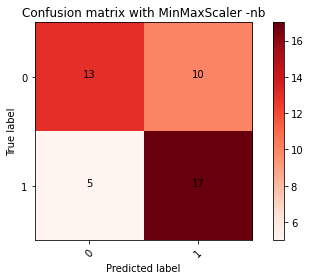

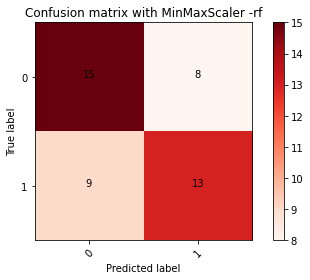

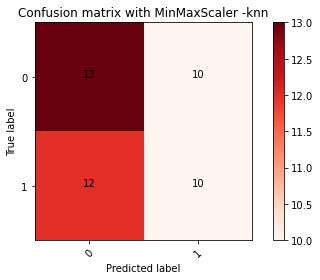

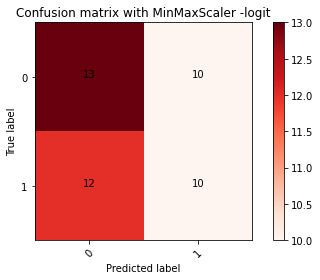

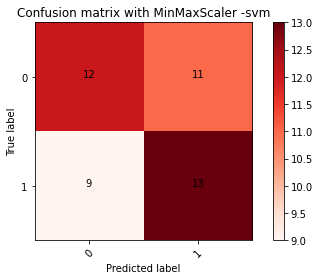

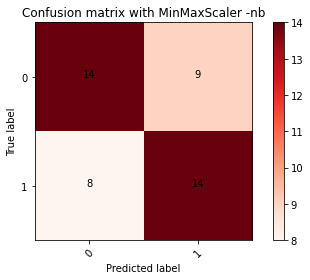

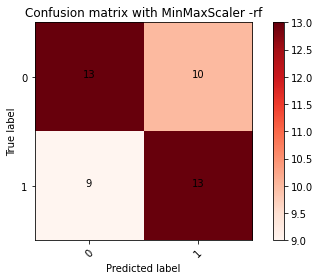

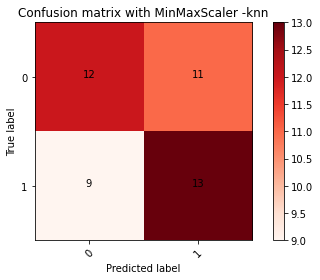

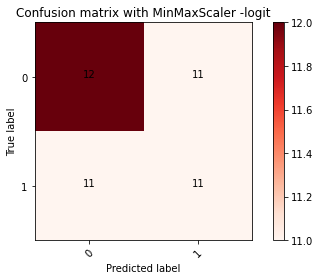

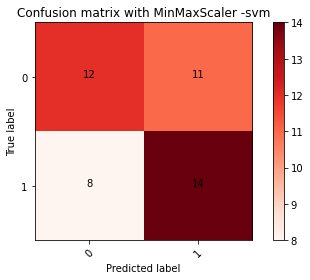

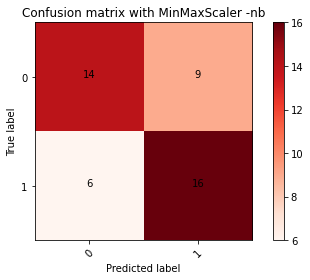

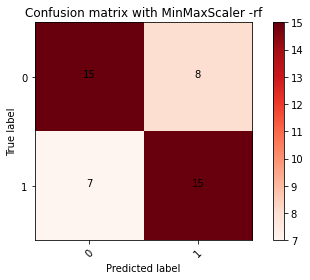

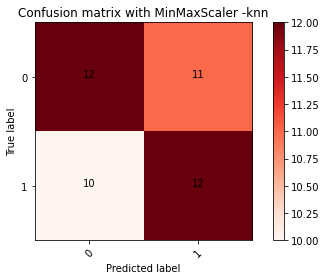

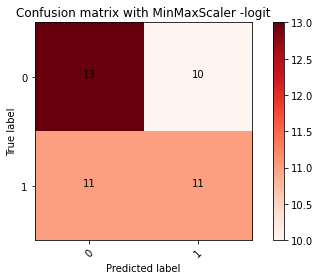

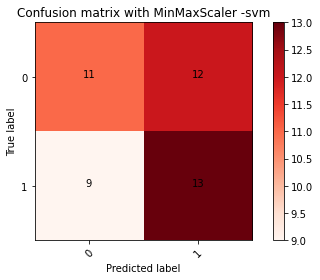

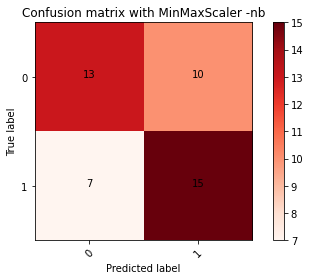

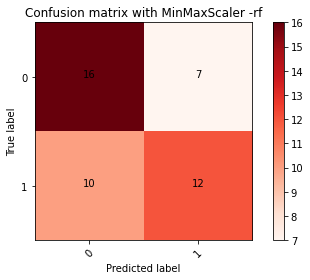

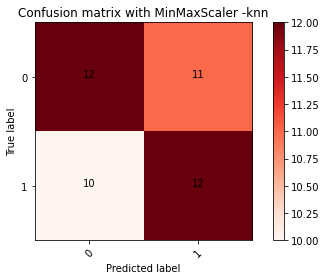

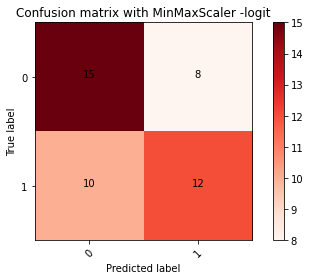

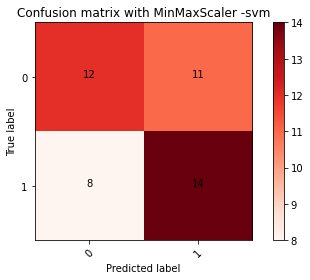

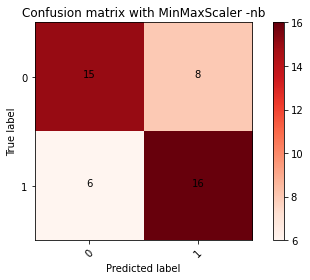

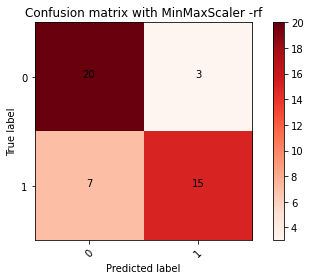

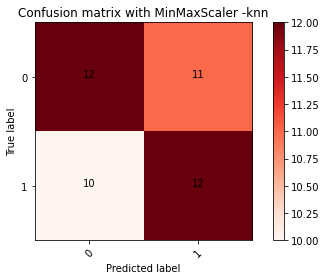

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
#variance = [95, 90, 80, 70, 60]
#variance=[95]
var_val = 95
#for var_val in variance:
for exec in range(1,11):
  #PCA
  i=0
  #AGGIUNGERE PRECISION, RECALL, E MATRICI DI CONFUSIONE
  dict_model = { "logit": {"accuracy": [], "precision": [], "recall": []},
                  "svm": {"accuracy": [], "precision": [], "recall": []},
                  "rf": {"accuracy":  [], "precision": [], "recall": []}, 
                  "nb": {"accuracy":  [], "precision": [], "recall": []},
                  "knn": {"accuracy":  [], "precision": [], "recall": []},
                }
  

  pca = PCA(float("0."+ str(var_val) ))   #manteniamo un numero di componenti tale che la varianza venga  mantenuta al 95%
  pca.fit(data_objs)
  print(pca.explained_variance_)

  print("Varianza mantenuta:  %", str(var_val))
  print("Componenti Pricipali: ", len(pca.components_))

  for train_idx, test_idx in fold_obj.split(data_objs, y):  
        i += 1
      
        X_train, X_test = data_objs[train_idx, :], data_objs[test_idx, :]
        #print("X_train", len(X_train))
        #print("X_test" , len(X_test))
        y_train, y_test = y[train_idx], y[test_idx]


        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)    

        dataset_training = X_train # data_objs[train_idx, :]
        y_status = y[train_idx]
        y_tipology = col_typology[train_idx]
        
            
        #fare oversampling su X_train e y_train
        #oversampling_training(dataset_training, y_status, y_tipology) #Test only function

        X_oversampled, y_oversampled = oversampling_training(dataset_training, y_status, y_tipology)

        #print("X_train oversampled", len(X_oversampled))
        #print("y_train oversampled", len(y_oversampled))

        X_train = X_oversampled
        y_train = y_oversampled

        print("TRAINING sample: ", len(X_train))
        print("TEST sample: ", len(X_test))

        # scatter plot of examples by class label
        #BUILD Logit
        logisticRegr = LogisticRegression(solver = 'lbfgs')  # handle L2 or no penalty
        logisticRegr.fit(X_train, y_train)
        test_predicted_logit[test_idx]  = logisticRegr.predict(X_test)
        print("Fold: " + str(i))

        #print("\t Accuracy Logit: %", accuracy_score(y_test, test_predicted_logit[test_idx])*100)

        #BUILD SVC
        model_svc = SVC(kernel='rbf')
        model_svc.fit(X_train, y_train) 
        test_predicted_svc[test_idx] = model_svc.predict(X_test)
     
        #print("\t Accuracy SVM: %", accuracy_score(y_test, test_predicted_svc[test_idx])*100)

        #BUILD RANDOM FOREST 
        clf = RandomForestClassifier(max_depth=None, random_state=0)
        clf.fit(X_train, y_train) 
        test_predicted_clf[test_idx] = clf.predict(X_test)
        #print("\t Accuracy RF:  %", accuracy_score(y_test, test_predicted_clf[test_idx])*100) 
              

        
        from sklearn.naive_bayes import GaussianNB
        #BUILD NAIVE BAYESIAN 
        model_naiveBay = GaussianNB()
        model_naiveBay.fit(X_train, y_train)
        test_predicted_bayes[test_idx] = model_naiveBay.predict(X_test)
        #print("\t Accuracy NB:  %", accuracy_score(y_test, test_predicted_bayes[test_idx])*100)

        #BUILD KNN
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X_train, y_train)
        test_predicted_knn[test_idx] = neigh.predict(X_test)


  print("End of kfold") 

  # Compute confusion matrix
  label = ["logit", "svm", "nb", "rf", "knn"]  
  dict_pred = {  "logit": {"y_pred": []},
                  "svm": {"y_pred": []},
                  "rf":  {"y_pred": []},
                  "nb":  {"y_pred": []},
                  "knn":  {"y_pred": []}, 
                }
    #SVM
  dict_pred['svm']['y_pred'].append(test_predicted_svc)
    #Logit 
  dict_pred['logit']['y_pred'].append(test_predicted_logit)
    #Rf
  dict_pred['rf']['y_pred'].append(test_predicted_clf)
    #Nb
  dict_pred['nb']['y_pred'].append(test_predicted_bayes)
    #Nb
  dict_pred['knn']['y_pred'].append(test_predicted_knn)

  for name in label: 
    y_pred = dict_pred[name]['y_pred']
    #print(y_pred[0])
    cnf_matrix = confusion_matrix(y, y_pred[0])
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    plt.figure()
    tit = 'Confusion matrix with MinMaxScaler -' + name 
    tit2 ='Confusion matrix with StandardScaler -' + name   #change
    plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                          title= tit)
    plt.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/mat_conf/' + tit +'.png')
    #plt.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/mat_conf/' + tit +'.png')


  print("\n\nRisultati metriche: \n")

  print("Accuracy SVM: ", accuracy_score(y,test_predicted_svc))
  print("Accuracy RF: ", accuracy_score(y,test_predicted_clf))
  print("Accuracy NB: ", accuracy_score(y,test_predicted_bayes))
  print("Accuracy LOGIT: ", accuracy_score(y,test_predicted_logit))
  print("Accuracy KNN: ", accuracy_score(y,test_predicted_knn))

  print("\nPrecision SVM: ", precision_score(y,test_predicted_svc))
  print("Precision RF: ", precision_score(y,test_predicted_clf))
  print("Precision NB: ", precision_score(y,test_predicted_bayes))
  print("Precision LOGIT: ", precision_score(y,test_predicted_logit))
  print("Precision KNN: ", precision_score(y,test_predicted_knn))

  print("\nRecall SVM: ", recall_score(y,test_predicted_svc))
  print("Recall RF: ", recall_score(y,test_predicted_clf))
  print("Recall NB: ", recall_score(y,test_predicted_bayes))
  print("Recall LOGIT: ", recall_score(y,test_predicted_logit))
  print("Recall KNN: ", recall_score(y,test_predicted_knn))

  #plot_confusion_matrix(clf, data_objs, y)  # doctest: +SKIP
  #plt.show() 

    #SVM
  dict_model['svm']['accuracy'].append(accuracy_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['accuracy'].append(accuracy_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['accuracy'].append(accuracy_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['accuracy'].append(accuracy_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['accuracy'].append(accuracy_score(y, test_predicted_knn))


    #SVM
  dict_model['svm']['precision'].append(precision_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['precision'].append(precision_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['precision'].append(precision_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['precision'].append(precision_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['precision'].append(precision_score(y, test_predicted_knn))



    #SVM
  dict_model['svm']['recall'].append(recall_score(y, test_predicted_svc))
    #Logit 
  dict_model['logit']['recall'].append(recall_score(y, test_predicted_logit))
    #Rf
  dict_model['rf']['recall'].append(recall_score(y, test_predicted_clf))
    #Nb
  dict_model['nb']['recall'].append(recall_score(y, test_predicted_bayes))
    #KNN
  dict_model['knn']['recall'].append(recall_score(y, test_predicted_knn))

  #j=0

  #Salvare dati variance pca sia per MinMax che per Standard Scaler
  for key in dict_model.keys():   
     np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(exec)  + 'accuracy_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['accuracy']))
     np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(exec)  + 'precision_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['precision']))
     np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(exec)  + 'recall_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['recall']))
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(exec)  + 'accuracy_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['accuracy']))
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(exec)  + 'precision_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['precision']))
     #np.save('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(exec)  + 'recall_'+ str(key) + str(n_fold) + '-fold', list(dict_model[key]['recall']))
  dict_model.clear()
  dict_pred.clear()

#PLOT TEN_RUN  PCA

[(0.5111111111111111, 0.5111111111111111, 0.5333333333333333, 0.5333333333333333, 0.5111111111111111, 0.5111111111111111, 0.5555555555555556, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333), (0.5555555555555556, 0.4888888888888889, 0.5777777777777777, 0.5555555555555556, 0.5111111111111111, 0.5555555555555556, 0.5555555555555556, 0.5777777777777777, 0.5333333333333333, 0.5777777777777777), (0.6888888888888889, 0.6666666666666666, 0.7111111111111111, 0.6, 0.7111111111111111, 0.6666666666666666, 0.6222222222222222, 0.6666666666666666, 0.6222222222222222, 0.6888888888888889), (0.6666666666666666, 0.6222222222222222, 0.6444444444444445, 0.6888888888888889, 0.7111111111111111, 0.6222222222222222, 0.5777777777777777, 0.6666666666666666, 0.6222222222222222, 0.7777777777777778)]
       Run1      Run2      Run3  ...      Run9     Run10  mean_accuracy
0  0.511111  0.511111  0.533333  ...  0.533333  0.533333       0.526667
1  0.555556  0.488889  0.577778  ...  0.533333  0.577778      

<Figure size 432x288 with 0 Axes>

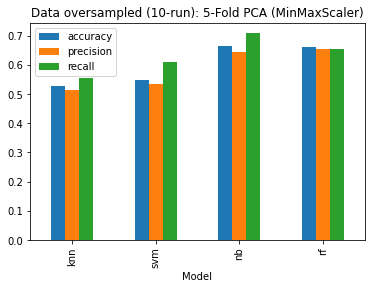

In [ ]:
#PLOT TEN_RUN  PCAa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_fold = 5
      #    0,    1   ,    2    ,3 
label = ["knn", "svm", "nb", "rf"]  
label_step =["Run1", "Run2","Run3","Run4","Run5","Run6","Run7","Run8","Run9", "Run10"]
dict_metrics = {"accuracy":[], "precision": [], "recall": []}
data_acc =[]
data_pre = []
data_rec = []


temp = []
for item in label:
  for e in range(1,11):

    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(e) + 'accuracy_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(e) + 'accuracy_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_acc.append(tuple(temp))
  temp.clear()

print(data_acc)


df_acc = pd.DataFrame(data_acc, columns = label_step) 

df_acc['mean_accuracy'] = df_acc.mean(axis=1)
print(df_acc)

#calcolo media precision su 10 run
for item in label:
  for e in range(1,11):

    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(e) + 'precision_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(e) + 'precision_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_pre.append(tuple(temp))
  temp.clear()

print(data_pre)


df_pre = pd.DataFrame(data_pre, columns = label_step) 
df_pre['mean_precision'] = df_pre.mean(axis=1)
print(df_pre)


#calcolo media recall su 10 run
for item in label:
  for e in range(1,11):

    value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/MinMaxScaler/var95/'+ str(e) + 'recall_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
    #value = np.load('/content/drive/My Drive/dati/last_test/ten_run/PCA/StandardScaler/var95/'+ str(e) + 'recall_'+ item + str(n_fold) + '-fold.npy', allow_pickle=True)
      #print(value)
    for v in value: 
        temp.append(v)
          
  #print(tuple(temp))
  data_rec.append(tuple(temp))
  temp.clear()

print(data_rec)


df_rec = pd.DataFrame(data_rec, columns = label_step) 
df_rec['mean_recall'] = df_rec.mean(axis=1)
print(df_rec)

item_l, item_precision, item_recall = [] , [] , []
item_l = df_acc['mean_accuracy'].tolist()
item_precision =df_pre['mean_precision'].tolist()
item_recall =df_rec['mean_recall'].tolist() 

print(item_l)
print(item_precision)
print(item_recall)
for i in range(0, len(label)):
 df_acc = df_acc.rename(index={i: label[i]})
print(df_acc)
ax = sns.heatmap(df_acc, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_acc = ax.get_figure()
fig_acc.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_minmax/' + "df_acc"  +".png")
#fig_acc.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_standardScaler/' + "df_acc"  +".png")
fig_acc.clear()

for i in range(0, len(label)):
 df_pre = df_pre.rename(index={i: label[i]})
print(df_pre)
ax_pre = sns.heatmap(df_pre, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_pre = ax_pre.get_figure()
fig_pre.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_minmax/' + "df_pre"  +".png")
#fig_pre.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_standardScaler/' + "df_pre"  +".png")
fig_pre.clear()
for i in range(0, len(label)):
 df_rec = df_rec.rename(index={i: label[i]})
print(df_rec)
ax_rec= sns.heatmap(df_rec, annot=True, fmt=".2f",  cmap="YlGnBu")
fig_rec = ax_rec.get_figure()
fig_rec.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_minmax/' + "df_rec"  +".png")
#fig_rec.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/dataframe/df_standardScaler/' + "df_rec"  +".png")
fig_rec.clear()

df = pd.DataFrame({'accuracy':item_l,'precision': item_precision, 'recall': item_recall, 'Model': label})
title = "Data oversampled (10-run): " + str(n_fold) + "-Fold " + "PCA (MinMaxScaler)"
title2 = "Data oversampled (10-run): " + str(n_fold) + "-Fold " + "PCA (StandardScaler)" 
plot = df.plot(x= 'Model', kind='bar', legend=True, title = title)
fig = plot.get_figure()
fig.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/' + title + '.png')
#fig.savefig('/content/drive/My Drive/dati/last_test/ten_run/PCA/Plot/' + title2 + '.png')